In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [2]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 학습 데이터 전처리

네이버 쇼핑 리뷰 데이터 불러오기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7ff0401ba690>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


별점으로 긍정 부정 Labelling진행
(긍정 :1, 부정 :0)

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


불용어 제거

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

형태소 분석 & 불용어 제거

In [ ]:
mecab = Mecab()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


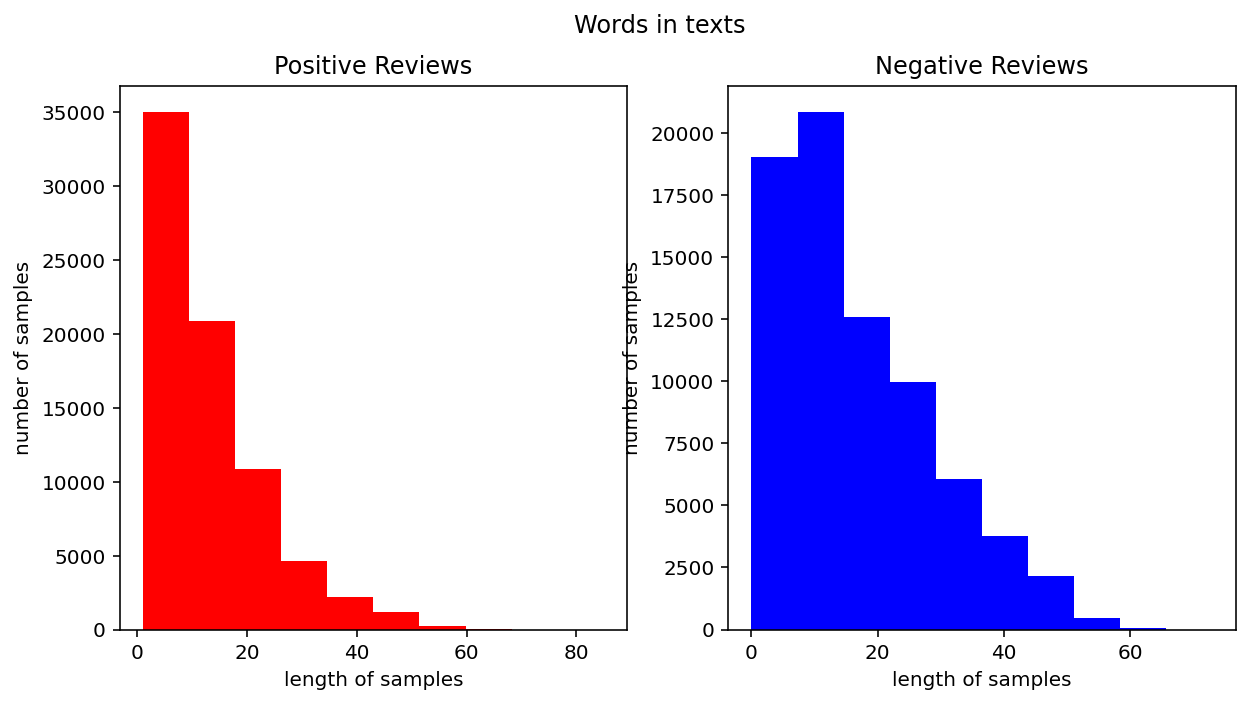

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

Vectorization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.79352492030765


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') # unindexed words as OOV
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) # words to numbers
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


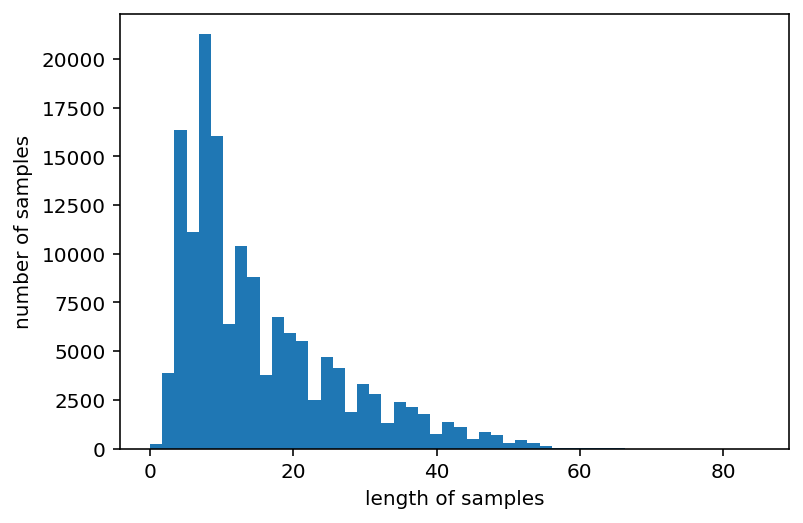

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


Padding

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# GRU 모델 이용해서 학습시키기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 201s 99ms/step - loss: 0.2684 - acc: 0.8985 - val_loss: 0.2278 - val_acc: 0.9164

Epoch 00001: val_acc improved from -inf to 0.91636, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 200s 100ms/step - loss: 0.2147 - acc: 0.9219 - val_loss: 0.2204 - val_acc: 0.9208

Epoch 00002: val_acc improved from 0.91636 to 0.92077, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 198s 99ms/step - loss: 0.1987 - acc: 0.9286 - val_loss: 0.2020 - val_acc: 0.9285

Epoch 00003: val_acc improved from 0.92077 to 0.92854, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 198s 99ms/step - loss: 0.1880 - acc: 0.9337 - val_loss: 0.2051 - val_acc: 0.9262

Epoch 00004: val_acc did not improve from 0.92854
Epoch 5/15
2000/2000 [==============================] - 198s 99ms/step - loss: 0.1786 - acc: 0.9368 - val_loss: 0.2027 - val_acc: 0.9276

Epoch 0

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 28s 17ms/step - loss: 0.2093 - acc: 0.9256

 테스트 정확도: 0.9256


# LSTM을 이용해서 학습

In [ ]:
from tensorflow.keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 374s 186ms/step - loss: 0.2784 - acc: 0.8950 - val_loss: 0.2270 - val_acc: 0.9171

Epoch 00001: val_acc improved from -inf to 0.91710, saving model to best_model_2.h5
Epoch 2/15
2000/2000 [==============================] - 378s 189ms/step - loss: 0.2171 - acc: 0.9216 - val_loss: 0.2102 - val_acc: 0.9255

Epoch 00002: val_acc improved from 0.91710 to 0.92547, saving model to best_model_2.h5
Epoch 3/15
2000/2000 [==============================] - 374s 187ms/step - loss: 0.2006 - acc: 0.9282 - val_loss: 0.2104 - val_acc: 0.9250

Epoch 00003: val_acc did not improve from 0.92547
Epoch 4/15
2000/2000 [==============================] - 373s 187ms/step - loss: 0.1911 - acc: 0.9318 - val_loss: 0.2039 - val_acc: 0.9264

Epoch 00004: val_acc improved from 0.92547 to 0.92640, saving model to best_model_2.h5
Epoch 5/15
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1831 - acc: 0.9356 - val_loss: 0.2047 - val_acc: 0.926

In [ ]:
loaded_model = load_model('best_model_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 43s 27ms/step - loss: 0.2113 - acc: 0.9242

 테스트 정확도: 0.9242


따라서 더 성능이 좋은 GRU를 이용하기로 함

# 크롤링한 데이터 Load 및 긍부정 라벨링

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

  return score

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/데청캠

/content/gdrive/My Drive/데청캠


In [ ]:
train = pd.read_excel("고군산군도 카페리뷰 크롤링.xlsx")

In [ ]:
import re
train['review']=train['review'].map(lambda x: re.sub('[-,=.#/?:$}]','', x))
train['review'] = train['review'].map(lambda x: re.sub(r'\d+', '', x))

In [ ]:
train = train.reindex(columns = train.columns.tolist() + ["score_new"])

In [ ]:
for i in range(len(train)):
  train['score_new'][i] = sentiment_predict(train['review'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new
0,https://lh3.googleusercontent.com/a-/AOh14Gjm9...,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.990241
1,https://lh3.googleusercontent.com/a-/AOh14Gj5K...,J-do SONG,지역 가이드,・리뷰 424개,1년 전,동네 유일의 커피숍인가요 몇개 있을법한데 한참 찾아 헤매여봐도 안보이더군요 양으로...,카페드선유,0.278249
2,https://lh3.googleusercontent.com/a-/AOh14Gi2L...,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.972422
3,https://lh3.googleusercontent.com/a/AATXAJzwA8...,Seung Hun Lee,지역 가이드,・리뷰 25개,3달 전,커피맛이 % 부족합니다,카페드선유,0.131014
4,https://lh3.googleusercontent.com/a-/AOh14GhKs...,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.604127
...,...,...,...,...,...,...,...,...
1586,NaN,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.978690
1587,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351
1588,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351
1589,NaN,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.748858


## 긍부정 문장들 나누기

In [2]:
train = train.reindex(columns = train.columns.tolist() + ["pos_neg"])

NameError: ignored

In [3]:
train

NameError: ignored

In [ ]:
for i in range(len(train)):
  if train['score_new'][i] > 0.5:
    train['pos_neg'][i]= "긍정"
  else:
    train['pos_neg'][i]= "부정"

In [ ]:
#neg =train[train['pos_neg'] == '부정']
# neg.to_csv('neg.csv')

# pos =train[train['pos_neg'] == '긍정']
# pos.to_csv('pos.csv')

# 토픽모델링과 워드클라우드

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 448 kB 74.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-30 13:50:11--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [ ]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab

## 부정리뷰 긍정리뷰 Load

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/My Drive/데청캠

In [ ]:
neg = pd.read_csv('neg.csv').set_index('Unnamed: 0').rename_axis(index=None)

In [ ]:
pos = pd.read_csv('pos.csv').set_index('Unnamed: 0').rename_axis(index=None)

## 사용자사전 정의

In [561]:
cd /content/mecab-ko-dic-2.1.1-20180720

/content/mecab-ko-dic-2.1.1-20180720


In [562]:
ls user-dic

nnp.csv  person.csv  place.csv  README.md


In [563]:
# 각각 명사 사람 장소를 등록할 수 있는 csv

### 종성판별기

In [564]:
!pip install jamo

In [565]:
from jamo import h2j, j2hcj

def get_jongsung_TF(sample_text):
  sample_text_list = list(sample_text) 
  last_word = sample_text_list[-1] 
  last_word_jamo_list = list(j2hcj(h2j(last_word))) 
  last_jamo = last_word_jamo_list[-1] 

  jongsung_TF = "T" 

  if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']: 
    jongsung_TF = "F" 
    
  return jongsung_TF

### 사용자사전 단어추가

In [5]:
with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
  nnp = f.readlines()

add_dict = ['라파르', '선유도', '고군산군도', '불편', '손님','카페라파르','환야갤러리','다타고','도겸찻집',\
            '그섬애','카페마실','바다향기카페','장자스토리','호떡당','전망좋은집','아이리스커피', '한라봉', '에이드', '비쌈']

for w in add_dict:
  jongsung = get_jongsung_TF(w)
  nnp.append( '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(w,jongsung,w) )

with open("./user-dic/nnp.csv", 'w', encoding='utf-8') as f:
  for line in nnp:
    f.write(line)

with open("./user-dic/nnp.csv", 'r', encoding='utf-8') as f:
  nnp = f.readlines()
nnp

FileNotFoundError: ignored

In [6]:
!bash ./tools/add-userdic.sh

bash: ./tools/add-userdic.sh: No such file or directory


In [7]:
!make install

make: *** No rule to make target 'install'.  Stop.


In [8]:
cd /content/gdrive/My Drive/데청캠

[Errno 2] No such file or directory: '/content/gdrive/My Drive/데청캠'
/content


## 부정어 (업로드, 다운로드 및) 전처리

In [ ]:
neg

In [ ]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','또는','및','의','로'] #불용어 설정
    stopwords = stopwords + '합니다 습니다 입니다 세요 예요 어요 네요 해서 했 았 시 는데 거 기 어요 아요 어 되 아 그 음 null nan 에서 것 면 만\
    요 는데 은데 에요 셨 할 며 함 진짜 정말 지만 인데 으로 그리고 어서 면서 라고 아서 으면 까지 인지 으나 이나 구요 카페 커피 선유도 선유 해요 넘 너무 곳 데 서 었 점 였 오 나 라\
    있 안 좋 실 갔 덜 아니 않 안 주'.split()
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import konlpy
from konlpy.tag import Mecab
import re

In [ ]:
neg = neg['review']

In [ ]:
review_neg, mecab = text_preprocessing(neg)
review_neg = list(filter(None, review_neg))

## 토픽모델(LDA)을 이용한 부정어 토픽 분류

In [475]:
pip install --upgrade tomotopy

In [594]:
import tomotopy as tp 

num_k=3

model = tp.LDAModel(k=num_k, alpha=0.1, eta=0.01, min_cf=5)
# LDAModel을 생성합니다.
# 토픽의 개수(k)는 20개, alpha 파라미터는 0.1, eta 파라미터는 0.01
# 전체 말뭉치에 5회 미만 등장한 단어들은 제거할 겁니다.
 
# 다음 구문은 input_file.txt 파일에서 한 줄씩 읽어와서 model에 추가합니다.
for i in range(len(review_neg)):
    model.add_doc(review_neg[i]) # 공백 기준으로 단어를 나누어 model에 추가합니다.
#    if i % 10 == 0: print('Document #{} has been loaded'.format(i))
 
# model의 num_words나 num_vocabs 등은 train을 시작해야 확정됩니다.
# 따라서 이 값을 확인하기 위해서 train(0)을 하여 실제 train은 하지 않고
# 학습 준비만 시킵니다.
# num_words, num_vocabs에 관심 없다면 이부분은 생략해도 됩니다.
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
# 다음 구문은 train을 총 200회 반복하면서, 
# 매 단계별로 로그 가능도 값을 출력해줍니다.
# 혹은 단순히 model.train(200)으로 200회 반복도 가능합니다.
for i in range(200):
#    print('Iteration {}\tLL per word: {}'.format(i, model.ll_per_word))
    model.train(1)
 
# 학습된 토픽들을 출력해보도록 합시다.
for i in range(model.k):
    # 토픽 개수가 총 20개이니, 0~19번까지의 토픽별 상위 단어 top_n개를 뽑아봅시다.
    res = model.get_topic_words(i, top_n=30)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))
print('perplexity:',model.perplexity)

# Use fequency of the word as weight
frequencies = list(np.zeros(num_k))
df_frequencies = list(np.zeros(num_k))
for i in range(num_k):
  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
  b = pd.DataFrame(model.get_topic_words(i,50))
  df_frequencies[i] = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
  df_frequencies[i].columns=['words','fq']
  frequencies[i] = df_frequencies[i].set_index('words').to_dict()['fq']

# frequency sum for each topic
for i in range(num_k):
  print(f'frequency sum for the {i}th topic words:',sum(frequencies[i].values()))

Total docs: 297
Total words: 1255
Vocab size: 127
Topic #0	그냥, 직원, 불친절, 좀, 할리스, 분, 적, 같, 친절, 주문, 기분, 싫, 개, 쓰, 생, 싶, 보, 느낌, 불, 메뉴, 시간, 일, 매장, 두, 손, 님, 엔, 못, 위치, 양
Topic #1	뷰, 사람, 많, 주차, 차, 쏘, 좁, 자리, 주차장, 수, 맛집, 옆, 층, 불편, 마시, 공간, 앞, 협소, 커피숍, 횟집, 힘들, 때문, 앉, 사진, 이런, 들어가, 길, 해수욕장, 주말, 줄
Topic #2	맛, 없, 가격, 별로, 먹, 음료, 비싸, 버거, 맛없, 햄버거, 화장실, 보통, 맛있, 라떼, 한라봉, 보다, 대비, 밖, 건물, 원, 하나, 바다, 보이, 수제, 작, 생각, 번, 비쌈, 분위기, 비싼
perplexity: 148.49687719666693
frequency sum for the 0th topic words: 378.0
frequency sum for the 1th topic words: 429.0
frequency sum for the 2th topic words: 468.0


In [601]:
# (Optional) Use probability of the word in the topic as weight
df = list(np.zeros(num_k))
for i in range(num_k):
  df[i] = pd.DataFrame(model.get_topic_words(i,50))
  frequencies[i] = df[i].set_index(0).to_dict()[1]

In [614]:
# Save words and its probability in the topic as csv
#for i in range(num_k):
#  df[i].to_csv(f'df_neg_topic_prob_50_{i}.csv')

In [623]:
# Load words and its probability in the topic as csv
for i in range(num_k):
  frequencies[i] = pd.read_csv(f'df_neg_topic_prob_50_{i}.csv').set_index('0').to_dict()['1']

In [478]:
# (Optional) Use geomean of fequency and probability of the word in the topic as weight
#df = list(np.zeros(num_k))
#for i in range(num_k):
#  df[i] = pd.merge(df_frequencies[i],pd.DataFrame(model.get_topic_words(i,50)),'inner',left_on='words',right_on=0).drop(0,axis=1) # DataFrame [words, frequency, probability in the topic]
#  df[i]['geomean']=(df[i]['fq']*df[i][1])**0.5
#  frequencies[i] = df[i].set_index('words').to_dict()['geomean']

In [479]:
# words and its probability in the topic -> DataFrame -> csv

#for i in range(4):
#  pd.DataFrame(model.get_topic_words(i,100)).to_csv(f'df_topic_prob_{i}_neg_100.csv')

In [480]:
#save 100 words and frequencies for each topic

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,100))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_neg_100.csv')

In [481]:
# save 50 words and frequencies for each topic (better than 100)

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,50))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_neg.csv')

In [482]:
# word frequency in negative words 기준 df 가졍오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic{i}_neg.csv').set_index('words').to_dict()['fq']

In [483]:
# probability in the topic 기준 df 가져오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic_prob_{i}_neg_100.csv').set_index('0').to_dict()['1']

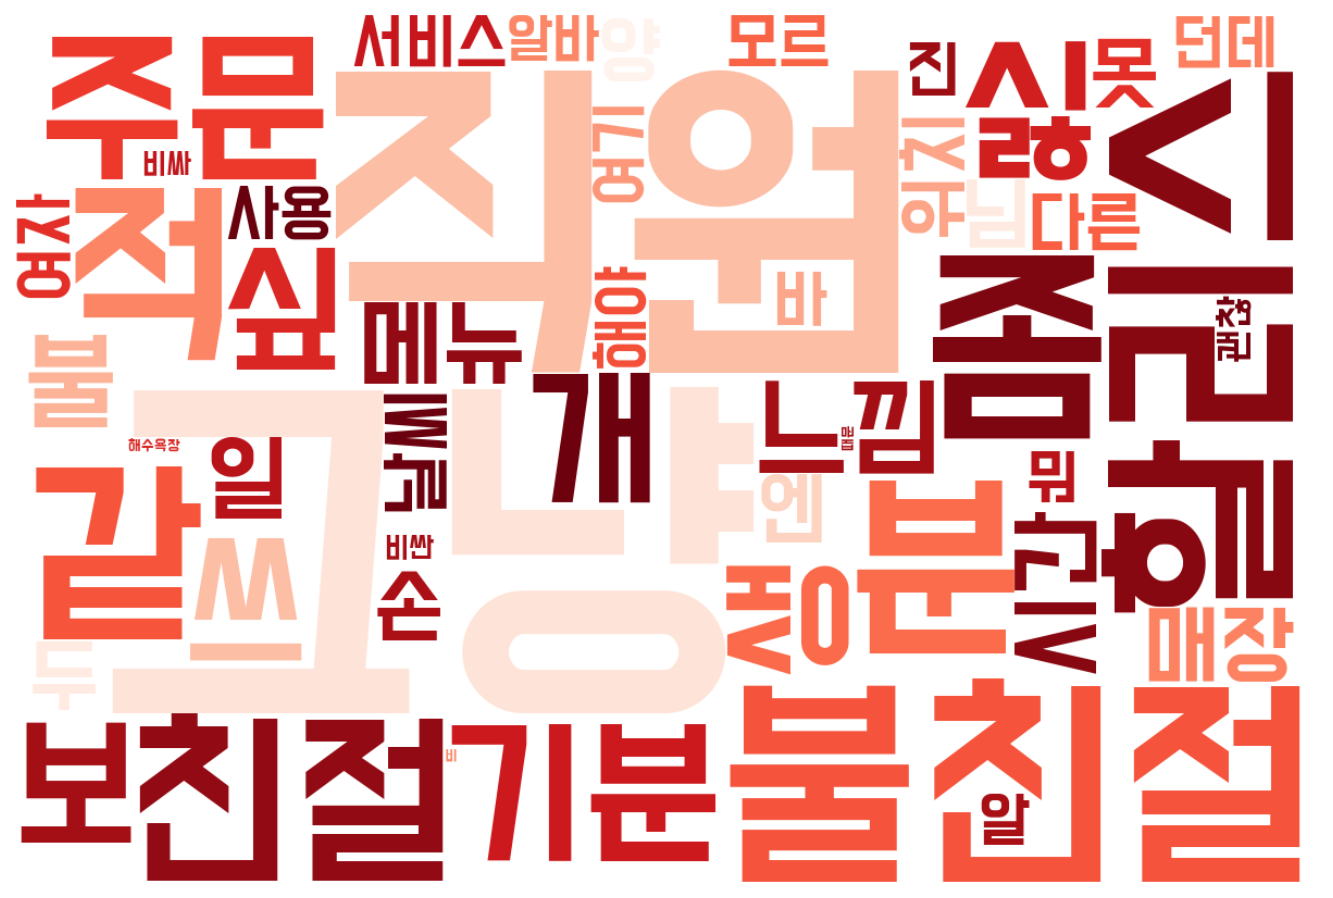

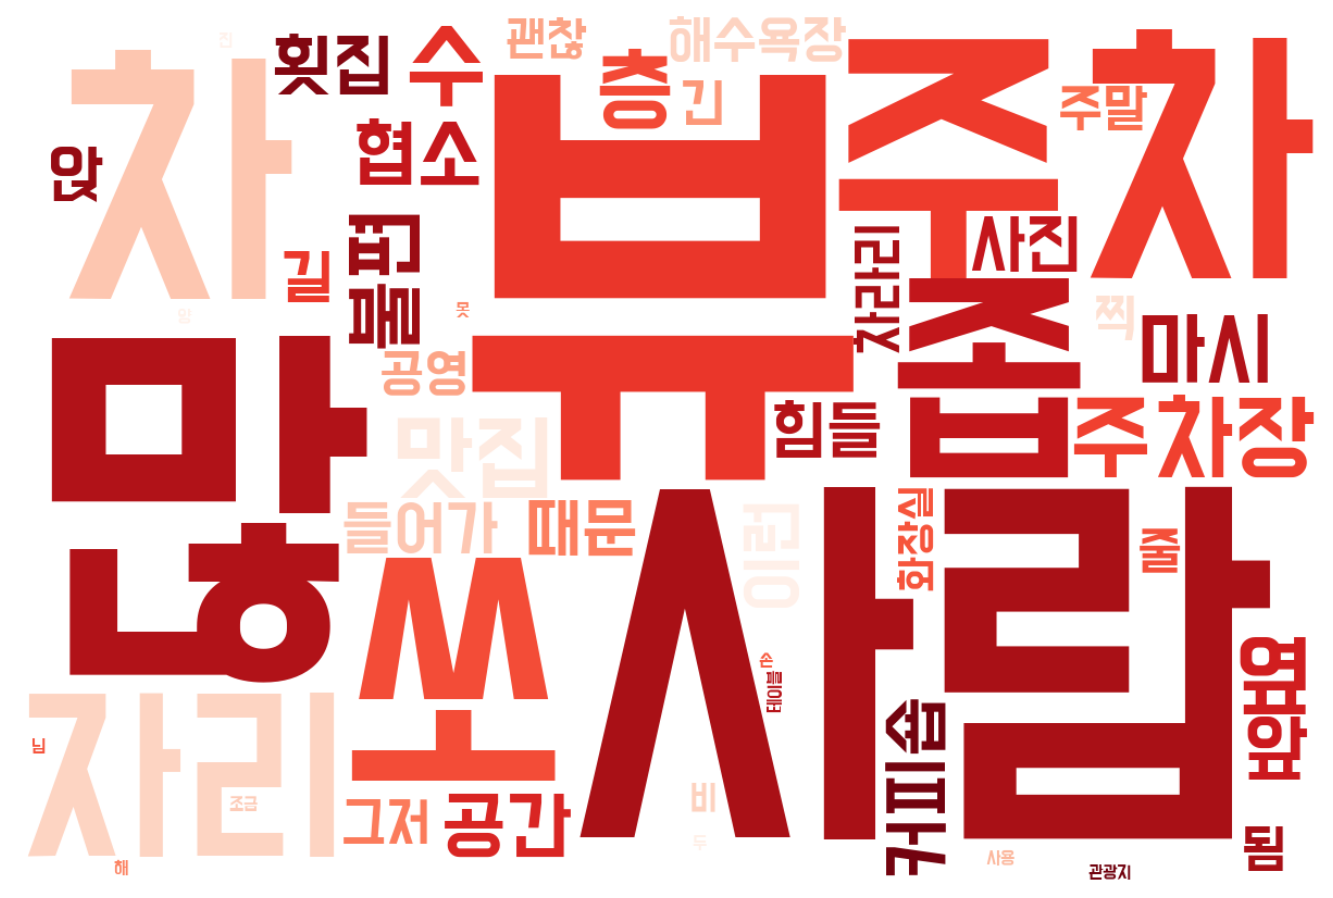

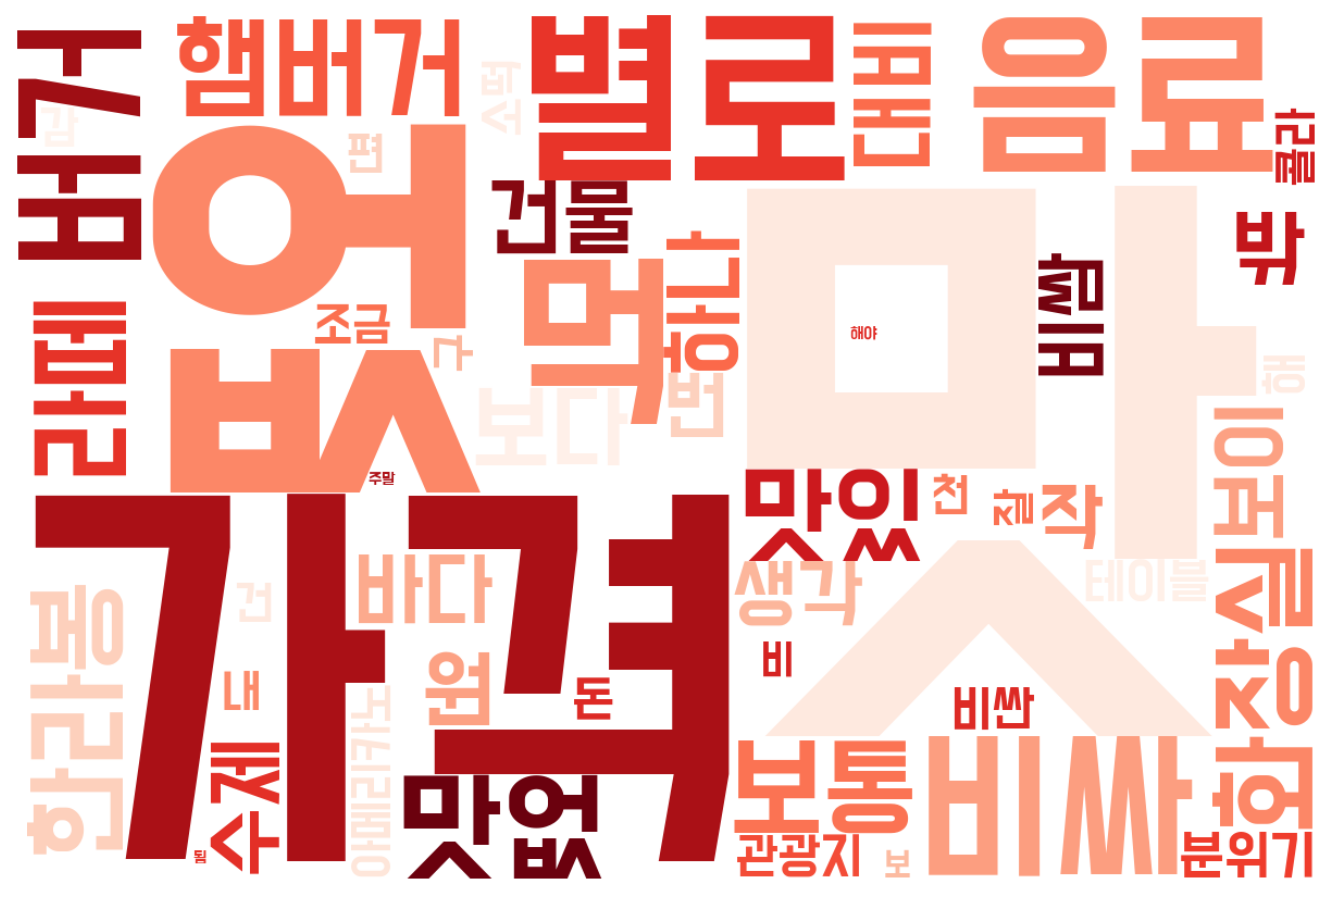

In [624]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

num_K = num_k

for i in range(num_K):
  wordcloud = WordCloud( colormap='Reds', background_color='white', width = 1200, height = 800, font_path='/content/gdrive/MyDrive/데청캠/BMDOHYEON_ttf.ttf').generate_from_frequencies( frequencies[i] )
  array = wordcloud.to_array()

  plt.figure(figsize=(12,8))
  plt.imshow(array, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  print('\n')

## 긍정어 (업로드, 다운로드 및) 전처리

In [628]:
pos

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
0,https://lh3.googleusercontent.com/a-/AOh14Gjm9...,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.990241,긍정
2,https://lh3.googleusercontent.com/a-/AOh14Gi2L...,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.972422,긍정
4,https://lh3.googleusercontent.com/a-/AOh14GhKs...,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.604127,긍정
5,https://lh3.googleusercontent.com/a-/AOh14Gh1f...,커핀보이,지역 가이드,・리뷰 153개,1년 전,깨끗하고 바닷가상점 비해서 정감있고 뷰도 좋아요\n그에비해 가격은 착한편,카페드선유,0.937109,긍정
7,https://lh3.googleusercontent.com/a-/AOh14GhbR...,이건희,지역 가이드,・리뷰 233개,2년 전,선유도에서 깔끔하고 멋있는 카페는 여기뿐입니다,카페드선유,0.974616,긍정
...,...,...,...,...,...,...,...,...,...
1586,NaN,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.978690,긍정
1587,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1588,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1589,NaN,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.748858,긍정


In [629]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','또는','및','의','로'] #불용어 설정
    stopwords = stopwords + '합니다 습니다 입니다 세요 예요 어요 네요 해서 했 았 시 는데 거 기 어요 아요 어 되 아 그 음 null nan 에서 것 면 만\
    요 는데 은데 에요 셨 할 며 함 진짜 정말 지만 인데 으로 그리고 어서 면서 라고 아서 으면 까지 인지 으나 이나 구요 카페 커피 선유도 선유 해요 넘 너무 곳 데 서 었 점 였 오 나 라\
    있 안 좋 실 갔 덜 아니 않 안 주'.split()
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [630]:
plt.rc('font', family='NanumBarunGothic') 

In [631]:
import konlpy
from konlpy.tag import Mecab
import re

In [632]:
pos = pos['review']

In [633]:
review_pos, mecab = text_preprocessing(pos)
review_pos = list(filter(None, review_pos))

## 토픽모델(LDA)을 이용한 긍정어 토픽 분류

In [634]:
pip install --upgrade tomotopy

In [657]:
import tomotopy as tp 

num_k=3

model = tp.LDAModel(k=num_k, alpha=0.1, eta=0.01, min_cf=5)
# LDAModel을 생성합니다.
# 토픽의 개수(k)는 20개, alpha 파라미터는 0.1, eta 파라미터는 0.01
# 전체 말뭉치에 5회 미만 등장한 단어들은 제거할 겁니다.
 
# 다음 구문은 input_file.txt 파일에서 한 줄씩 읽어와서 model에 추가합니다.
for i in range(len(review_pos)):
    model.add_doc(review_pos[i]) # 공백 기준으로 단어를 나누어 model에 추가합니다.
#    if i % 10 == 0: print('Document #{} has been loaded'.format(i))
 
# model의 num_words나 num_vocabs 등은 train을 시작해야 확정됩니다.
# 따라서 이 값을 확인하기 위해서 train(0)을 하여 실제 train은 하지 않고
# 학습 준비만 시킵니다.
# num_words, num_vocabs에 관심 없다면 이부분은 생략해도 됩니다.
model.train(0) 
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
# 다음 구문은 train을 총 200회 반복하면서, 
# 매 단계별로 로그 가능도 값을 출력해줍니다.
# 혹은 단순히 model.train(200)으로 200회 반복도 가능합니다.
for i in range(200):
#    print('Iteration {}\tLL per word: {}'.format(i, model.ll_per_word))
    model.train(1)
 
# 학습된 토픽들을 출력해보도록 합시다.
for i in range(model.k):
    # 토픽 개수가 총 20개이니, 0~19번까지의 토픽별 상위 단어 top_n개를 뽑아봅시다.
    res = model.get_topic_words(i, top_n=30)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))
print('perplexity:',model.perplexity)

# Use fequency of the word as weight
frequencies = list(np.zeros(num_k))
df_frequencies = list(np.zeros(num_k))
for i in range(num_k):
  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
  b = pd.DataFrame(model.get_topic_words(i,50))
  df_frequencies[i] = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
  df_frequencies[i].columns=['words','fq']
  frequencies[i] = df_frequencies[i].set_index('words').to_dict()['fq']

# frequency sum for each topic
for i in range(num_k):
  print(f'frequency sum for the {i}th topic words:',sum(frequencies[i].values()))

Total docs: 1041
Total words: 4420
Vocab size: 274
Topic #0	맛있, 맛, 친절, 보, 먹, 님, 경치, 사장, 잘, 버스, 라떼, 버거, 시원, 수제, 니, 햄버거, 가격, 사진, 예쁘, 해, 인테리어, 맛나, 한라봉, 생각, 찍, 한잔, 방문, 보다, 엄청, 넓
Topic #1	바다, 같, 주차, 수, 층, 많, 자리, 전망, 없, 시간, 사람, 분, 주차장, 괜찮, 보이, 공간, 건물, 무료, 잔, 차, 주문, 음료, 날, 추천, 조금, 마시, 테라스, 직원, 앉, 원
Topic #2	뷰, 굿, 맛있, 분위기, 맛집, 바다, 앞, 맛, 최고, 친절, 음료, 짱, 호떡, 풍경, 좁, 실내, 적, 조아, 좀, 구, 긴, 장자, 밖, 마셨, 굳, 내부, 일몰, 이뻐요, 양, 여
perplexity: 233.4320053435964
frequency sum for the 0th topic words: 1386.0
frequency sum for the 1th topic words: 1039.0
frequency sum for the 2th topic words: 1490.0


In [647]:
# (Optional) Use probability of the word in the topic as weight
df = list(np.zeros(num_k))
for i in range(num_k):
  df[i] = pd.DataFrame(model.get_topic_words(i,50))
  frequencies[i] = df[i].set_index(0).to_dict()[1]

In [648]:
# Save words and its probability in the topic as csv
#for i in range(num_k):
#  df[i].to_csv(f'df_pos_topic_prob_50_{i}.csv')

In [649]:
# Load words and its probability in the topic as csv
#for i in range(num_k):
#  frequencies[i] = pd.read_csv(f'df_pos_topic_prob_50_{i}.csv').set_index('0').to_dict()['1']

In [ ]:
# (Optional) Use geomean of fequency and probability of the word in the topic as weight
#df = list(np.zeros(num_k))
#for i in range(num_k):
#  df[i] = pd.merge(df_frequencies[i],pd.DataFrame(model.get_topic_words(i,50)),'inner',left_on='words',right_on=0).drop(0,axis=1) # DataFrame [words, frequency, probability in the topic]
#  df[i]['geomean']=(df[i]['fq']*df[i][1])**0.5
#  frequencies[i] = df[i].set_index('words').to_dict()['geomean']

In [ ]:
# words and its probability in the topic -> DataFrame -> csv

#for i in range(4):
#  pd.DataFrame(model.get_topic_words(i,100)).to_csv(f'df_topic_prob_{i}_pos_100.csv')

In [ ]:
#save 100 words and frequencies for each topic

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,100))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_pos_100.csv')

In [ ]:
# save 50 words and frequencies for each topic (better than 100)

#for i in range(4):
#  a = pd.DataFrame([list(model.used_vocabs),list(model.used_vocab_df)]).T
#  b = pd.DataFrame(model.get_topic_words(i,50))
#  c = pd.merge(b,a,'left',on=0).drop('1_x',axis=1)
#  c.columns=['words','fq']
#  c.to_csv(f'df_topic{i}_pos.csv')

In [ ]:
# word frequency in positive words 기준 df 가졍오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic{i}_pos.csv').set_index('words').to_dict()['fq']

In [ ]:
# probability in the topic 기준 df 가져오기
#frequencies = [0,0,0,0]
#for i in range(4):
#  frequencies[i] = pd.read_csv(f'df_topic_prob_{i}_pos_100.csv').set_index('0').to_dict()['1']

In [1]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

num_K = num_k

for i in range(num_K):
  wordcloud = WordCloud( background_color='white', width = 1200, height = 800, font_path='/content/gdrive/MyDrive/데청캠/BMDOHYEON_ttf.ttf').generate_from_frequencies( frequencies[i] )
  array = wordcloud.to_array()

  plt.figure(figsize=(12,8))
  plt.imshow(array, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  print('\n')

NameError: ignored

## 부정어 전체 워드클라우드

In [ ]:
#token들을 하나의 list로 합쳐주기!
result = []
for i in range(len(review_neg)):
  result.extend(review_neg[i])

In [ ]:
import nltk
from nltk import collocations

from konlpy.tag import Okt, Kkma
from konlpy.utils import pprint

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
ko = nltk.Text(result)

In [ ]:
def wc(ko,num_words_):
    print( '단어수:',len(ko.tokens) , '안겹치는단어수:', len(set(ko.tokens)) )
    plt.figure(figsize=(12,5))
    ko.plot(50)
    plt.show()
    
    num_words = num_words_
    data = ko.vocab().most_common(num_words)
    wordcloud = WordCloud( background_color='white', font_path='/content/gdrive/MyDrive/chung_proj/BMDOHYEON_ttf.ttf').generate_from_frequencies(dict(data))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
ko_elim = [ x for x in ko if (x not in 불용어) & (len(x)>1) ]
print( len(ko), len(ko_elim) )
ko_elim = nltk.Text(ko_elim)

4627 1928


단어수: 1928 안겹치는단어수: 928


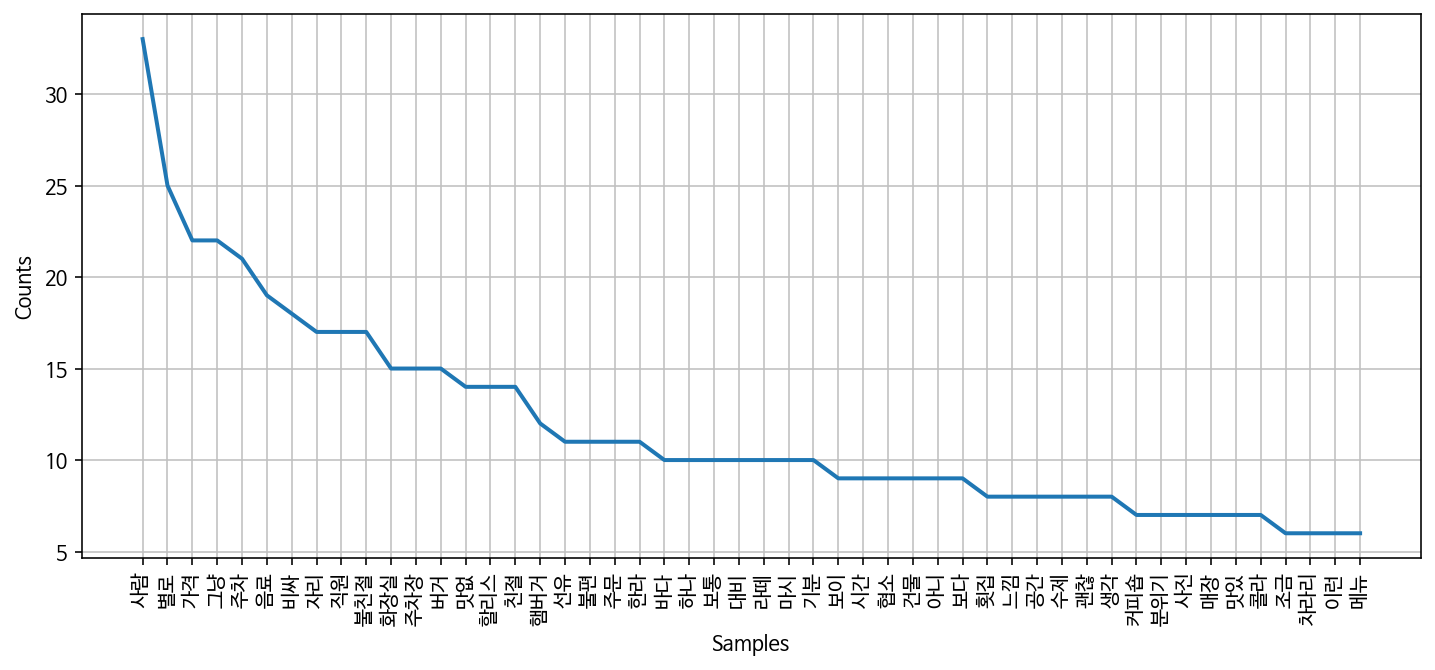

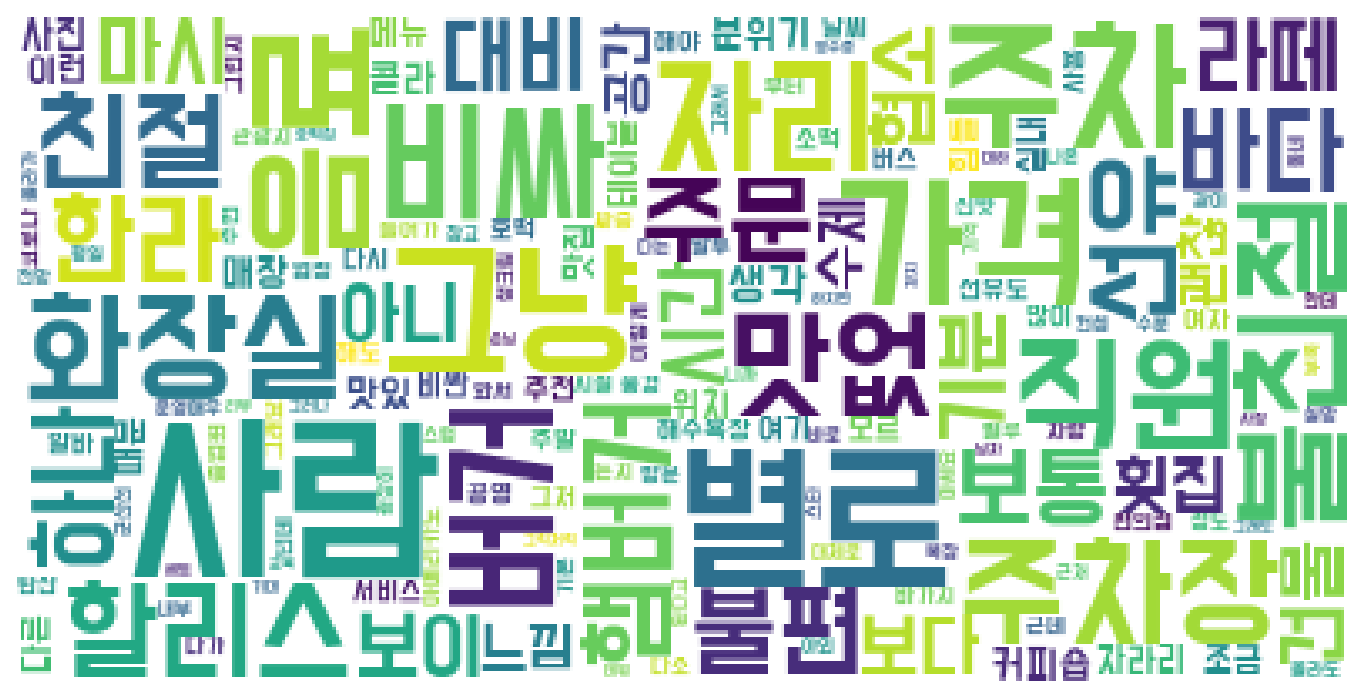

In [ ]:
wc(ko_elim,500)

## 긍정어 전체 워드클라우드

In [ ]:
# pos =train[train['pos_neg'] == '긍정']

# pos.to_csv('pos.csv')

In [ ]:
pos = pd.read_csv('pos.csv').set_index('Unnamed: 0').rename_axis(index=None)

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
0,https://lh3.googleusercontent.com/a-/AOh14Gjm9...,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.990241,긍정
2,https://lh3.googleusercontent.com/a-/AOh14Gi2L...,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.972422,긍정
4,https://lh3.googleusercontent.com/a-/AOh14GhKs...,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.604127,긍정
5,https://lh3.googleusercontent.com/a-/AOh14Gh1f...,커핀보이,지역 가이드,・리뷰 153개,1년 전,깨끗하고 바닷가상점 비해서 정감있고 뷰도 좋아요\n그에비해 가격은 착한편,카페드선유,0.937109,긍정
7,https://lh3.googleusercontent.com/a-/AOh14GhbR...,이건희,지역 가이드,・리뷰 233개,2년 전,선유도에서 깔끔하고 멋있는 카페는 여기뿐입니다,카페드선유,0.974616,긍정
...,...,...,...,...,...,...,...,...,...
1586,NaN,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.978690,긍정
1587,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1588,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.867351,긍정
1589,NaN,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.748858,긍정


In [ ]:
pos =pos['review']

In [ ]:
review_pos, mecab = text_preprocessing(pos)

In [ ]:
#token들을 하나의 list로 합쳐주기!
result2 = []
for i in range(len(review_pos)):
  result2.extend(review_pos[i])

In [ ]:
ko2 = nltk.Text(result2)

In [ ]:
ko_elim2 = [ x for x in ko2 if (x not in 불용어) & (len(x)>1) ]
print( len(ko2), len(ko_elim2) )
ko_elim2 = nltk.Text(ko_elim2)

11355 4455


단어수: 4455 안겹치는단어수: 1320


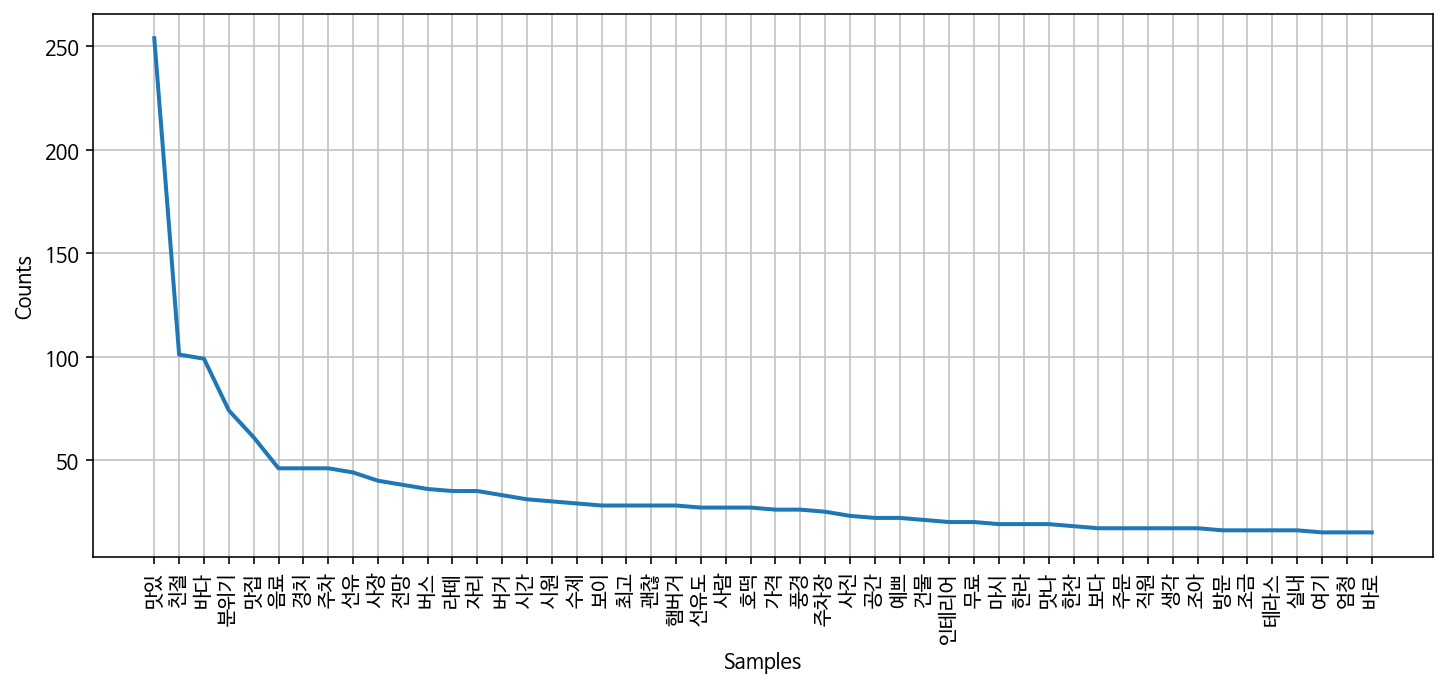

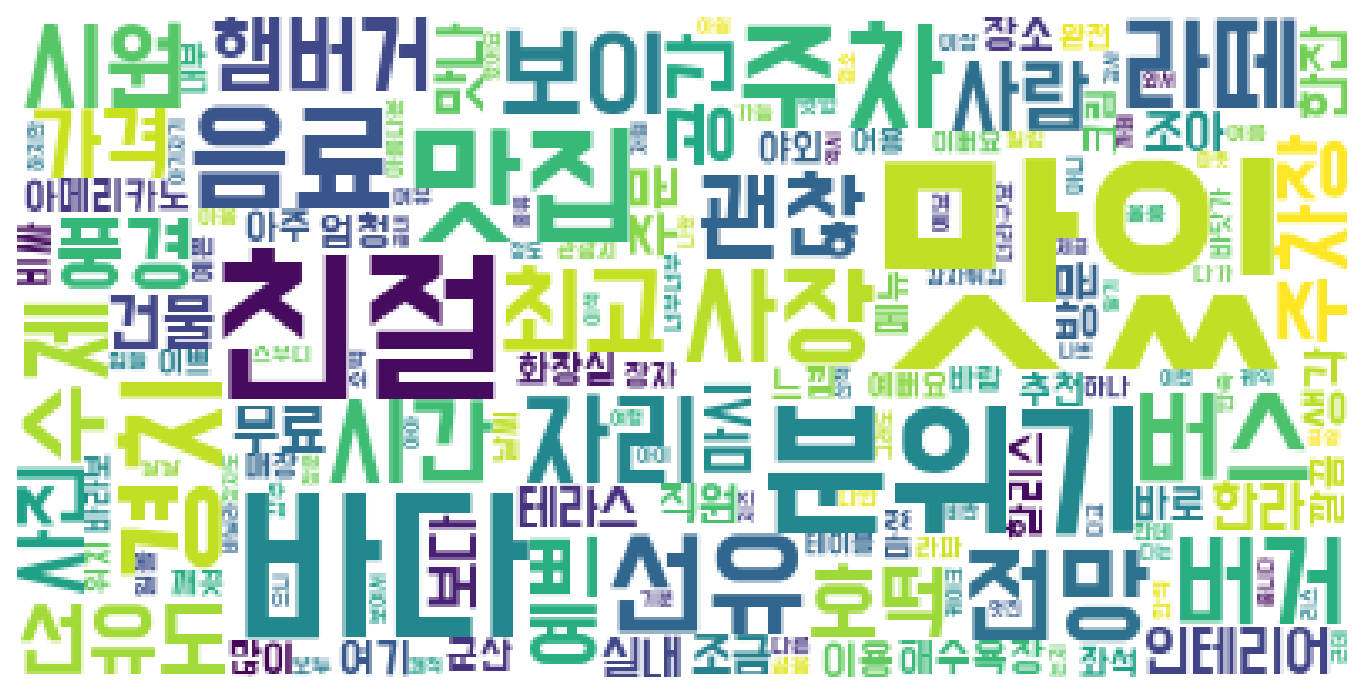

In [ ]:
wc(ko_elim2,500)